In [306]:
import pandas as pd
import numpy as np
np.random.seed(1337)
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [307]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

In [308]:
def clean_data(x, y=None, scaler=None):
    x = x.drop('patient_id', axis=1)
    x = pd.get_dummies(x)
    x = x.drop('thal_reversible_defect', axis=1)
    if y is not None:
        y = y['heart_disease_present']
    if scaler is None:
        scaler = StandardScaler().fit(x)
    x = scaler.transform(x)
    return scaler, x, y

In [309]:
# serum_cholesterol_mg_per_dl 0.006364026902311748
# resting_blood_pressure 0.00616315049709204
# fasting_blood_sugar_gt_120_mg_per_dl 1.1418131993679026e-05

In [310]:
x = pd.read_csv('../../Data/train_values.csv')
y = pd.read_csv('../../Data/train_labels.csv')
x_test = pd.read_csv('../../Data/test_values.csv')
patient_id_test = x_test['patient_id']

x_test = x_test.drop('patient_id', axis=1)
x_test = x_test.drop('serum_cholesterol_mg_per_dl', axis=1)
x_test = x_test.drop('resting_blood_pressure', axis=1)
x_test = x_test.drop('fasting_blood_sugar_gt_120_mg_per_dl', axis=1)

x = x.drop('patient_id', axis=1)
x = x.drop('serum_cholesterol_mg_per_dl', axis=1)
x = x.drop('resting_blood_pressure', axis=1)
x = x.drop('fasting_blood_sugar_gt_120_mg_per_dl', axis=1)
y = y['heart_disease_present']
x.head()

,slope_of_peak_exercise_st_segment,thal,chest_pain_type,num_major_vessels,resting_ekg_results,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,1,normal,2,0,2,0.0,1,45,170,0
1,2,normal,3,0,0,1.6,0,54,158,0
2,1,normal,4,3,2,0.0,1,77,162,1
3,1,reversible_defect,4,0,0,0.0,1,40,181,0
4,3,reversible_defect,1,0,2,4.2,1,59,145,0


In [311]:
categorical_vars= ['thal', 'chest_pain_type']
for col in x.columns:
    if col not in categorical_vars:
        mean = x[col].mean()
        std = x[col].std()
        x[col] = (x[col] - mean)/std
        
x = pd.get_dummies(x, columns=categorical_vars)

x = x.drop('chest_pain_type_1', axis=1)
x = x.drop('thal_normal', axis=1)
# x = x.drop('fasting_blood_sugar_gt_120_mg_per_dl_1', axis=1)

x.head()
# if scaler is None:
#     scaler = StandardScaler().fit(x)
# x = scaler.transform(x)

,slope_of_peak_exercise_st_segment,num_major_vessels,resting_ekg_results,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_fixed_defect,thal_reversible_defect,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4
0,-0.888762,-0.716404,0.951196,-0.900694,0.670152,-1.051032,0.929891,-0.678852,0,0,1,0,0
1,0.727169,-0.716404,-1.051322,0.526148,-1.483908,-0.086892,0.386007,-0.678852,0,0,0,1,0
2,-0.888762,2.378462,0.951196,-0.900694,0.670152,2.377024,0.567302,1.464891,0,0,0,0,1
3,-0.888762,-0.716404,-1.051322,-0.900694,0.670152,-1.586666,1.428452,-0.678852,0,1,0,0,1
4,2.343100,-0.716404,0.951196,2.844768,0.670152,0.448742,-0.203201,-0.678852,0,1,0,0,0


In [312]:
for col in x_test.columns:
    if col not in categorical_vars:
        mean = x_test[col].mean()
        std = x_test[col].std()
        x_test[col] = (x_test[col] - mean)/std
        
x_test = pd.get_dummies(x_test, columns=categorical_vars)

x_test = x_test.drop('chest_pain_type_1', axis=1)
x_test = x_test.drop('thal_normal', axis=1)

In [313]:
# patient_id_test = x_test['patient_id']
# scaler, x, y = clean_data(x, y)
# _, x_test, _ = clean_data(x_test, None, scaler)

In [314]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## Logistic Regression

In [315]:
steps = [('scaler', StandardScaler()), ('classifier', LogisticRegression())]
pipeline = Pipeline(steps)

In [316]:
pipeline.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [317]:
print(pipeline.score(x_val, y_val))

0.8611111111111112


In [318]:
y_pred_prob = pipeline.predict_proba(x_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc_score(y_val, y_pred_prob)

0.9124999999999999

In [319]:
thresholds = np.arange(0, 1, 0.05)
for threshold in thresholds:
    y_pred = [0 if y_prob < threshold else 1 for y_prob in y_pred_prob]
    print(np.round(threshold,2), '\t', (y_pred == y_val).mean())

0.0 	 0.5555555555555556
0.05 	 0.5833333333333334
0.1 	 0.7777777777777778
0.15 	 0.8055555555555556
0.2 	 0.7777777777777778
0.25 	 0.8055555555555556
0.3 	 0.8888888888888888
0.35 	 0.8888888888888888
0.4 	 0.8611111111111112
0.45 	 0.8611111111111112
0.5 	 0.8611111111111112
0.55 	 0.8611111111111112
0.6 	 0.8611111111111112
0.65 	 0.8611111111111112
0.7 	 0.8055555555555556
0.75 	 0.7777777777777778
0.8 	 0.75
0.85 	 0.75
0.9 	 0.75
0.95 	 0.6111111111111112


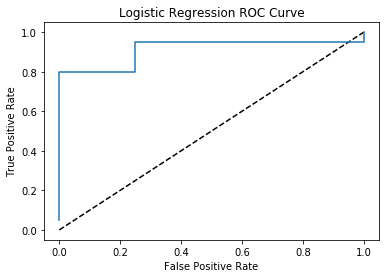

In [320]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

In [321]:
cv_scores = cross_val_score(pipeline, x, y, cv=5, scoring='roc_auc')
cv_scores

array([0.81875 , 0.921875, 0.996875, 0.815625, 0.846875])

## K-Neighbors

In [322]:
steps = [('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())]
pipeline = Pipeline(steps)
parameters = {'classifier__n_neighbors':np.arange(1, 50)}

In [323]:
cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [ ]:
y_pred = cv.predict(x_val)

In [ ]:
print(cv.best_params_)

{'classifier__n_neighbors': 24}


In [ ]:
print(cv.score(x_val, y_val))

0.7777777777777778


In [ ]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          0       0.67      1.00      0.80        16
          1       1.00      0.60      0.75        20

avg / total       0.85      0.78      0.77        36



## Deep Learning

In [ ]:
def to_string(model):
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    short_model_summary = "\n".join(stringlist)
    return short_model_summary

In [ ]:
n_cols = x.shape[1]
target = y
# target = to_categorical(y)
early_stopping_monitor = EarlyStopping(patience=2)
# n_nodes = range(n_cols)
n_nodes = range(n_cols//2, n_cols*3//2, 2)

best_model = None
best_history = None
max_acc = -1

history_lst = []
for _ in range(50):
    model = Sequential()
    model.add(Dense(n_cols//2, activation='relu', input_shape=(n_cols,), use_bias=True))
    model.add(Dense(n_cols, activation='relu', use_bias=True))
    model.add(Dense(n_cols*2, activation='relu', use_bias=True))
    model.add(Dense(1, activation='sigmoid', use_bias=True))
    optim = optimizers.SGD(lr=0.008)
    model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])
    history = model.fit(x, target, validation_split=0.20, epochs=500, callbacks = [early_stopping_monitor], verbose=False)
    history_lst.append(history.history['val_accuracy'][-1])
    if history.history['val_accuracy'][-1] > max_acc:
        max_acc = history.history['val_accuracy'][-1]
        best_history = history
        best_model = model
    
accuracy = np.mean(history_lst)
std = np.std(history_lst)
maxx = np.max(history_lst)
median = np.median(history_lst)


print('accuracy', accuracy, 'std', std, 'max', maxx, 'median', median)

#  "Accuracy"
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# model = best_model
history = model.fit(x, target, epochs=10, callbacks = [early_stopping_monitor], verbose=False)

In [ ]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(x_test)
predictions = predictions.reshape(90)
predictions

In [ ]:
def save_result(predictions, file_name='results.csv'):
    results = pd.DataFrame()
    results['patient_id'] = patient_id_test
    results['heart_disease_present'] = predictions
    results.to_csv('results.csv', index=False)
    return results

In [ ]:
results = save_result(predictions)
results